추가 회고 : 

In [4]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
import gensim
gensim.__version__

'3.4.0'

In [6]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
    train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
    train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
    train_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
    train_data = train_data.dropna(how='any') # Null 값 제거
    
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
    test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
    test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
    test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
    test_data = test_data.dropna(how='any') # Null 값 제거
    
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

/tmp/ipykernel_1501/2860097851.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_1501/2860097851.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
/tmp/ipykernel_1501/2860097851.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_1501/2860097851.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[27, 67, 891, 33, 214, 15, 28, 698]
라벨:  0
1번째 리뷰 문장 길이:  8
2번째 리뷰 문장 길이:  13


In [52]:
print(get_decoded_sentence(X_train[0], index_to_word)) # 부정 0
print('라벨: ', X_train[0])  # 1번째 리뷰데이터의 라벨

print(get_decoded_sentence(X_train[4], index_to_word)) # 긍정 1
print('라벨: ', X_train[4])

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 진짜 짜증 나 네요 목소리
라벨:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  27  67 891  33 214  15  28 698]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <UNK> 익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  [   0    0    0    0    0    0    0    0    0    2 8488 1049   47 2698
   54    4 2620   34 1116   29  323   36   17   35   54    2    2  393
 2875 1674    5]


In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 1.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  13.927888796879312
문장길이 최대 :  83
문장길이 표준편차 :  11.454835366606218
pad_sequences maxlen :  31
전체 문장의 0.910472946580629%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)


print(X_train.shape)

(143620, 31)


In [12]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(113620, 31)
(113620,)


RNN

In [13]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 3488      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
222/222 [==============================] - 5s 7ms/step - loss: 0.4713 - accuracy: 0.7967 - val_loss: 0.3681 - val_accuracy: 0.8396
Epoch 2/20
222/222 [==============================] - 1s 6ms/step - loss: 0.3426 - accuracy: 0.8555 - val_loss: 0.3560 - val_accuracy: 0.8430
Epoch 3/20
222/222 [==============================] - 1s 5ms/step - loss: 0.3166 - accuracy: 0.8680 - val_loss: 0.3576 - val_accuracy: 0.8434
Epoch 4/20
222/222 [==============================] - 1s 6ms/step - loss: 0.3000 - accuracy: 0.8753 - val_loss: 0.3589 - val_accuracy: 0.8451
Epoch 5/20
222/222 [==============================] - 1s 6ms/step - loss: 0.2839 - accuracy: 0.8825 - val_loss: 0.3620 - val_accuracy: 0.8462
Epoch 6/20
222/222 [==============================] - 1s 6ms/step - loss: 0.2679 - accuracy: 0.8903 - val_loss: 0.3704 - val_accuracy: 0.8449
Epoch 7/20
222/222 [==============================] - 1s 6ms/step - loss: 0.2511 - accuracy: 0.8974 - val_loss: 0.3793 - val_accuracy: 0.8449
Epoch 

In [15]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1513/1513 - 3s - loss: 0.7324 - accuracy: 0.8284
[0.7324377298355103, 0.8283907771110535]


In [16]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


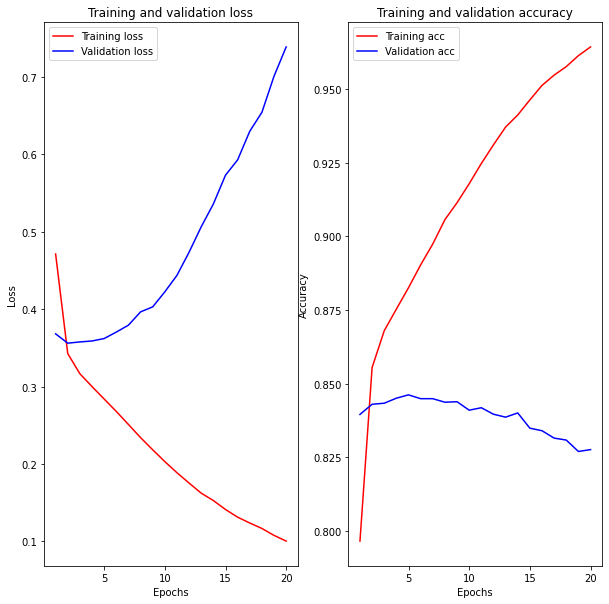

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [19]:
pip install --upgrade gensim --user

  Using cached gensim-4.1.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [20]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [22]:
word_vectors.similar_by_word("진짜")

[('매우', 0.7289503812789917),
 ('정말', 0.7093715071678162),
 ('졸라', 0.6585070490837097),
 ('긴장감', 0.6209666728973389),
 ('이번', 0.6136350631713867),
 ('개인', 0.610276460647583),
 ('바램', 0.5977984070777893),
 ('성장통', 0.5925370454788208),
 ('보다', 0.5867720246315002),
 ('터짐', 0.5848726630210876)]

In [23]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]


In [24]:
from tensorflow.keras.initializers import Constant


global_max_pooling1d

In [25]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 100)           1000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
222/222 [==============================] - 1s 4ms/step - loss: 0.6661 - accuracy: 0.6857 - val_loss: 0.5877 - val_accuracy: 0.7950
Epoch 2/20
222/222 [==============================] - 1s 4ms/step - loss: 0.4694 - accuracy: 0.8280 - val_loss: 0.4070 - val_accuracy: 0.8232
Epoch 3/20
222/222 [==============================] - 1s 4ms/step - loss: 0.3662 - accuracy: 0.8480 - val_loss: 0.3799 - val_accuracy: 0.8307
Epoch 4/20
222/222 [==============================] - 1s 3ms/step - loss: 0.3351 - accuracy: 0.8606 - val_loss: 0.3729 - val_accuracy: 0.8326
Epoch 5/20
222/222 [==============================] - 1s 4ms/step - loss: 0.3159 - accuracy: 0.8686 - val_loss: 0.3719 - val_accuracy: 0.8357
Epoch 6/20
222/222 [==============================] - 1s 4ms/step - loss: 0.3017 - accuracy: 0.8747 - val_loss: 0.3758 - val_accuracy: 0.8344
Epoch 7/20
222/222 [==============================] - 1s 4ms/step - loss: 0.2892 - accuracy: 0.8808 - val_loss: 0.3755 - val_accuracy: 0.8358
Epoch 

In [27]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1513/1513 - 2s - loss: 0.4899 - accuracy: 0.8223
[0.4898717999458313, 0.822294294834137]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


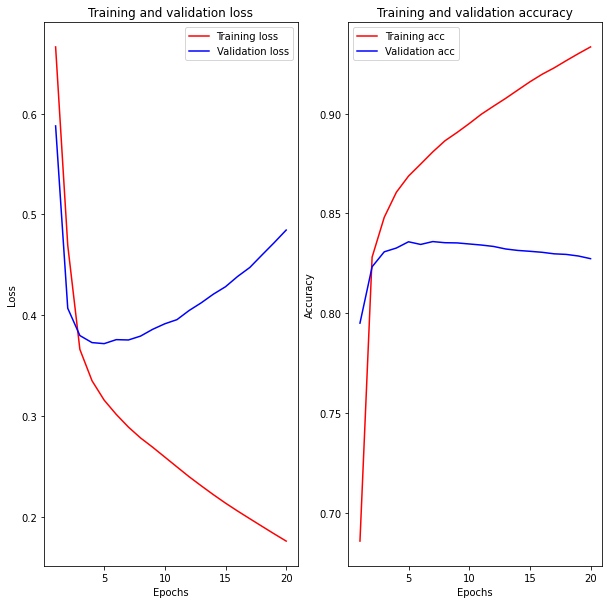

In [28]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

GRU

In [29]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(tf.keras.layers.GRU(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 31, 100)           1000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,088,449
Trainable params: 1,088,449
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
222/222 [==============================] - 3s 10ms/step - loss: 0.3501 - accuracy: 0.8521 - val_loss: 0.3602 - val_accuracy: 0.8415
Epoch 2/20
222/222 [==============================] - 2s 8ms/step - loss: 0.2761 - accuracy: 0.8854 - val_loss: 0.3921 - val_accuracy: 0.8415
Epoch 3/20
222/222 [==============================] - 2s 8ms/step - loss: 0.2236 - accuracy: 0.9083 - val_loss: 0.4329 - val_accuracy: 0.8405
Epoch 4/20
222/222 [==============================] - 2s 8ms/step - loss: 0.1854 - accuracy: 0.9253 - val_loss: 0.4687 - val_accuracy: 0.8397
Epoch 5/20
222/222 [==============================] - 2s 8ms/step - loss: 0.1592 - accuracy: 0.9367 - val_loss: 0.5049 - val_accuracy: 0.8355
Epoch 6/20
222/222 [==============================] - 2s 8ms/step - loss: 0.1399 - accuracy: 0.9450 - val_loss: 0.5679 - val_accuracy: 0.8318
Epoch 7/20
222/222 [==============================] - 2s 8ms/step - loss: 0.1253 - accuracy: 0.9516 - val_loss: 0.6444 - val_accuracy: 0.8325
Epoch

In [31]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1513/1513 - 3s - loss: 1.1823 - accuracy: 0.8210
[1.1823325157165527, 0.8209923505783081]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


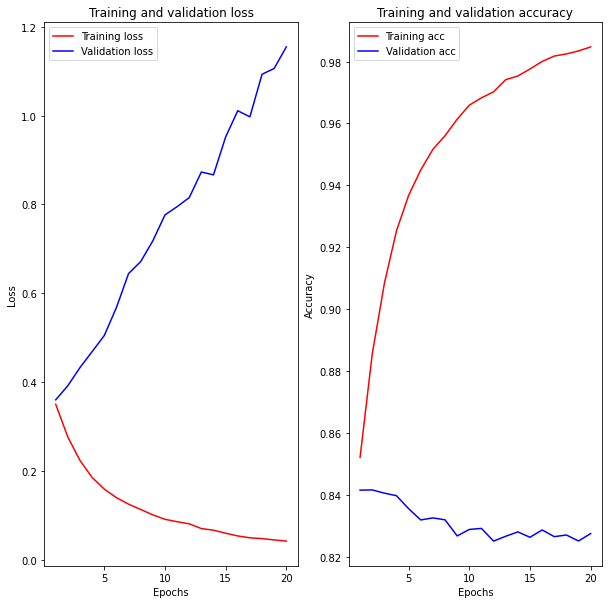

In [32]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

LSTM

In [33]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 31, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
222/222 [==============================] - 3s 7ms/step - loss: 0.4477 - accuracy: 0.8138 - val_loss: 0.3734 - val_accuracy: 0.8416
Epoch 2/20
222/222 [==============================] - 1s 6ms/step - loss: 0.3108 - accuracy: 0.8723 - val_loss: 0.3636 - val_accuracy: 0.8425
Epoch 3/20
222/222 [==============================] - 1s 6ms/step - loss: 0.2799 - accuracy: 0.8856 - val_loss: 0.3668 - val_accuracy: 0.8445
Epoch 4/20
222/222 [==============================] - 1s 6ms/step - loss: 0.2495 - accuracy: 0.8983 - val_loss: 0.3751 - val_accuracy: 0.8443
Epoch 5/20
222/222 [==============================] - 1s 5ms/step - loss: 0.2212 - accuracy: 0.9103 - val_loss: 0.3968 - val_accuracy: 0.8435
Epoch 6/20
222/222 [==============================] - 1s 6ms/step - loss: 0.1989 - accuracy: 0.9194 - val_loss: 0.4228 - val_accuracy: 0.8414
Epoch 7/20
222/222 [==============================] - 1s 6ms/step - loss: 0.1813 - accuracy: 0.9268 - val_loss: 0.4586 - val_accuracy: 0.8387
Epoch 

In [35]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1513/1513 - 3s - loss: 0.9057 - accuracy: 0.8213
[0.9056727886199951, 0.8212816715240479]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


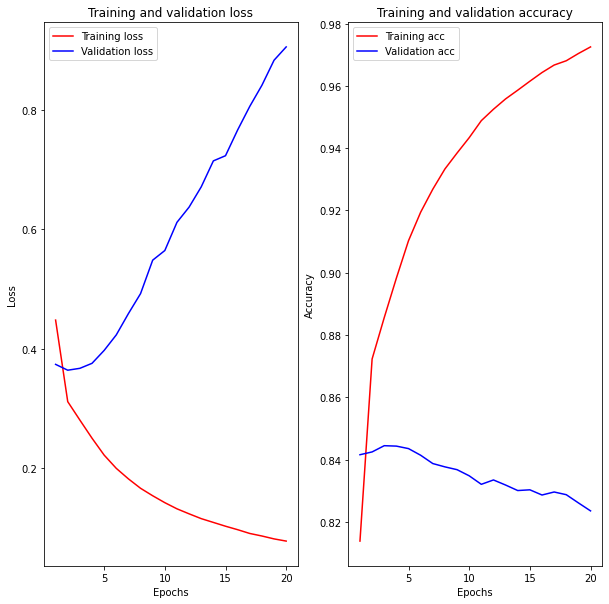

In [36]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig , ax = plt.subplots(1,2,figsize = (10,10))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

대체 왜.. word2vec 적용하지 않은 LSTM이 적용한 LSTM보다 성능이 좋게 나오는걸까

일반 LSTM :1513/1513 - 3s - loss: 0.6885 - accuracy: 0.8241   
W2V Global : 1513/1513 - 2s - loss: 0.5189 - accuracy: 0.8216   
W2V GRU : 1513/1513 - 3s - loss: 0.7660 - accuracy: 0.8213   
W2V LSTM : 1513/1513 - 3s - loss: 1.2308 - accuracy: 0.8111   

이렇게 모아두고 보니 accuracy 일반 LSTM이 제일 좋게 나왔지만,    
loss까지 고려하면 word2vec을 적용한 global도 나쁘지 않은 성적이라 생각이 들었다.

## word2vec 한국어 적용

In [48]:
import gensim
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [49]:
word2vec.similar_by_word("노래")

/tmp/ipykernel_1501/1343737346.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("노래")


[('가사', 0.7066930532455444),
 ('곡조', 0.6870777010917664),
 ('곡', 0.6749094724655151),
 ('발라드', 0.6573207378387451),
 ('멜로디', 0.6572505235671997),
 ('주제가', 0.6365448832511902),
 ('애국가', 0.6258596181869507),
 ('곡인', 0.6254721879959106),
 ('히트곡', 0.6253563165664673),
 ('원곡', 0.6200122833251953)]

사람이 봤을 때 꽤 유사한 단어들이 추출되는 것이 보인다.

In [51]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 200으로 설정
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1501/1234835990.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1501/1234835990.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [85]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_basic = tf.keras.Sequential()
model_basic.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model_basic.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_basic.add(tf.keras.layers.Dense(8, activation='relu'))
model_basic.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_basic.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 31, 200)           2000000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [86]:
model_basic.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_basic = model_basic.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
222/222 [==============================] - 5s 13ms/step - loss: 0.4676 - accuracy: 0.7733 - val_loss: 0.3776 - val_accuracy: 0.8293
Epoch 2/10
222/222 [==============================] - 2s 11ms/step - loss: 0.3451 - accuracy: 0.8484 - val_loss: 0.3482 - val_accuracy: 0.8477
Epoch 3/10
222/222 [==============================] - 3s 11ms/step - loss: 0.2990 - accuracy: 0.8723 - val_loss: 0.3315 - val_accuracy: 0.8551
Epoch 4/10
222/222 [==============================] - 3s 11ms/step - loss: 0.2661 - accuracy: 0.8885 - val_loss: 0.3300 - val_accuracy: 0.8585
Epoch 5/10
222/222 [==============================] - 3s 11ms/step - loss: 0.2392 - accuracy: 0.9014 - val_loss: 0.3431 - val_accuracy: 0.8549
Epoch 6/10
222/222 [==============================] - 3s 11ms/step - loss: 0.2123 - accuracy: 0.9143 - val_loss: 0.3572 - val_accuracy: 0.8528
Epoch 7/10
222/222 [==============================] - 3s 11ms/step - loss: 0.1829 - accuracy: 0.9273 - val_loss: 0.3929 - val_accuracy: 0.8494

In [101]:
print("기본 LSTM 성능")
results_basic = model_basic.evaluate(X_test,  y_test, verbose=2)

기본 LSTM 성능
1513/1513 - 3s - loss: 0.5354 - accuracy: 0.8434


## 성능 향상을 위한 drop out 적용

LSTM의 성능 향상을 위해 drop out을 적용하였다.

In [88]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_drop = tf.keras.Sequential()
model_drop.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model_drop.add(tf.keras.layers.LSTM(128))   
model_drop.add(tf.keras.layers.Dropout(0.25))
model_drop.add(tf.keras.layers.Dense(8, activation='relu'))
model_drop.add(tf.keras.layers.Dropout(0.4))
model_drop.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_drop.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 31, 200)           2000000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dropout_12 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
___________________________________________

In [89]:
model_drop.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_drop = model_drop.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
222/222 [==============================] - 4s 13ms/step - loss: 0.5236 - accuracy: 0.7439 - val_loss: 0.3972 - val_accuracy: 0.8223
Epoch 2/10
222/222 [==============================] - 3s 11ms/step - loss: 0.3968 - accuracy: 0.8355 - val_loss: 0.3527 - val_accuracy: 0.8428
Epoch 3/10
222/222 [==============================] - 3s 11ms/step - loss: 0.3568 - accuracy: 0.8579 - val_loss: 0.3313 - val_accuracy: 0.8529
Epoch 4/10
222/222 [==============================] - 3s 11ms/step - loss: 0.3278 - accuracy: 0.8724 - val_loss: 0.3321 - val_accuracy: 0.8552
Epoch 5/10
222/222 [==============================] - 3s 12ms/step - loss: 0.3044 - accuracy: 0.8817 - val_loss: 0.3363 - val_accuracy: 0.8526
Epoch 6/10
222/222 [==============================] - 3s 12ms/step - loss: 0.2863 - accuracy: 0.8900 - val_loss: 0.3426 - val_accuracy: 0.8550
Epoch 7/10
222/222 [==============================] - 3s 12ms/step - loss: 0.2671 - accuracy: 0.8982 - val_loss: 0.3676 - val_accuracy: 0.8547

In [102]:
print("drop out 적용한 LSTM 성능")
results_drop = model_drop.evaluate(X_test,  y_test, verbose=2)

drop out 적용한 LSTM 성능
1513/1513 - 3s - loss: 0.4025 - accuracy: 0.8501


dropout 적용 이후 성능이 향상된 것을 확인할 수 있었다.

In [95]:
history_basic = history_basic.history
history_drop = history_drop.history

print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [97]:
#plot 그리기 함수화
import matplotlib.pyplot as plt

def make_plt(his_ver):
    acc = his_ver['accuracy']
    val_acc = his_ver['val_accuracy']
    loss = his_ver['loss']
    val_loss = his_ver['val_loss']

    epochs = range(1, len(acc) + 1)

    fig , ax = plt.subplots(1,2,figsize = (10,10))

    ax[0].plot(epochs, loss, 'r', label='Training loss')
    ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, acc, 'r', label='Training acc')
    ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
    ax[1].set_title('Training and validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

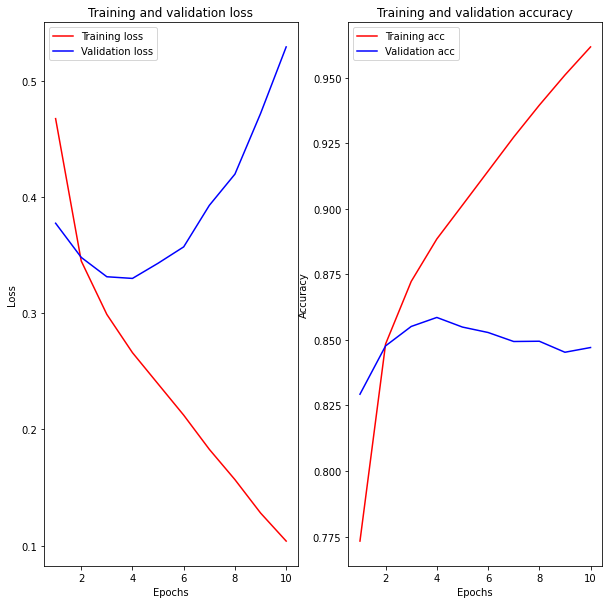

In [98]:
make_plt(history_basic) # non- drop out

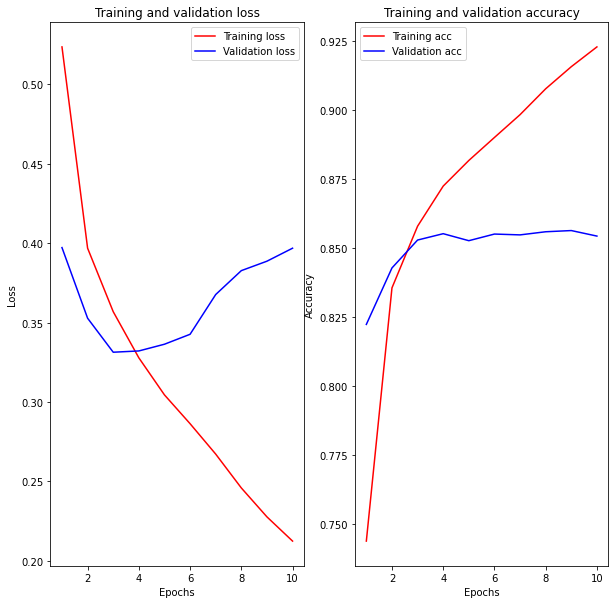

In [99]:
make_plt(history_drop) #drop out